# Compare SED for different ages at different t_obs or redshifts

https://dsps.readthedocs.io/en/latest/dsps_quickstart.html

This demo notebook begins by downloading the DSPS default option for the SSP spectral library. These data are stored at this URL in a flat hdf5 file with column names as expected by the dsps.load_ssp_templates function, which we will demonstrate below.

When downloading and storing SSP libraries, you can optionally use the DSPS_DRN environment variable to specify the default location where DSPS will look for SSP libraries. But here we’ll just save the downloaded data to tempdata.h5, directly pass the filename to the data loader. The load_ssp_templates that we’ll use to load these SSPs is just a convenience function - all of the DSPS functions that we’ll demonstrate in this notebook accept plain arrays and floats as inputs, and so you can store your SSP data on disk in whatever format you like.

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
import copy

In [15]:
import numpy as np

## Inspect the SSP data¶

In [16]:
#! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_fsps_v3.2_lgmet_age.h5 > tempdata.h5
#! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_continuum_fsps_v3.2_lgmet_age.h5 > tempdata_v2.h5

In [17]:
from dsps import load_ssp_templates
#ssp_data = load_ssp_templates(fn='tempdata_v2.h5')
ssp_data = load_ssp_templates(fn='tempdata.h5')

print(ssp_data._fields)

print('\nssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_lg_age_gyr.shape = {}'.format(ssp_data.ssp_lg_age_gyr.shape))
print('ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')

ssp_lgmet.shape = (12,)
ssp_lg_age_gyr.shape = (107,)
ssp_wave.shape = (5994,)
ssp_flux.shape = (12, 107, 5994)


In [33]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table
from dsps.cosmology import age_at_z, DEFAULT_COSMOLOGY

In [19]:
ssp_data.ssp_lgmet

array([-4.34771165, -3.84771165, -3.59771165, -3.34771165, -3.09771165,
       -2.84771165, -2.59771165, -2.34771165, -2.09771165, -1.84771165,
       -1.59771165, -1.34771165])

In [20]:
ssp_data.ssp_lg_age_gyr

array([-4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75, -3.7 , -3.65, -3.6 ,
       -3.55, -3.5 , -3.45, -3.4 , -3.35, -3.3 , -3.25, -3.2 , -3.15,
       -3.1 , -3.05, -3.  , -2.95, -2.9 , -2.85, -2.8 , -2.75, -2.7 ,
       -2.65, -2.6 , -2.55, -2.5 , -2.45, -2.4 , -2.35, -2.3 , -2.25,
       -2.2 , -2.15, -2.1 , -2.05, -2.  , -1.95, -1.9 , -1.85, -1.8 ,
       -1.75, -1.7 , -1.65, -1.6 , -1.55, -1.5 , -1.45, -1.4 , -1.35,
       -1.3 , -1.25, -1.2 , -1.15, -1.1 , -1.05, -1.  , -0.95, -0.9 ,
       -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 , -0.55, -0.5 , -0.45,
       -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,
        0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ])

The returned ssp_data is a namedtuple storing 4 ndarrays for the age-metallicity grid of the SSP spectra. Galaxy SEDs are calculated via probability-weighted sums of these spectral templates. For a galaxy observed at some, we’ll calculate the restframe SED of two different models in the cells below:

    a galaxy with a tabulated star formation history (SFH), and metallicity Z distributed as a lognormal about some median Z, using the calc_rest_sed_sfh_table_lognormal_mdf function.

    a galaxy with SFH table and also tabulated history of metallicity (ZH), using the calc_rest_sed_sfh_table_met_table function.

In the cells below, we’ll randomly generate an SFH and ZH for a galaxy, and then plot the results.

In [150]:
import numpy as np
# table of ages in 100 bins in linear scale from 50 millions to 13.8 billions years
gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr

# must put a true SFR using package diffstar
gal_sfr_table = np.zeros(len(gal_t_table)) # SFR in Msun/yr

# metallicity
gal_lgmet = -1.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

gal_lgmet_table = np.zeros(len(gal_t_table)) + gal_lgmet

In [151]:
NBSPECTRA = len(gal_t_table)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

The SED calculating functions require you specify the time of the observation, t_obs, rather than the redshift, z_obs. We’ll use the age_at_z function in dsps.cosmology to calculate the relationship between these two quantities, assuming the default redshift of DSPS. You could also use this same function to compute gal_t_table in case your input SFH is tabulated as a function of redshift.

In [152]:
all_redshifts = [0., 0.1, 0.5, 1.0, 3., 5.]

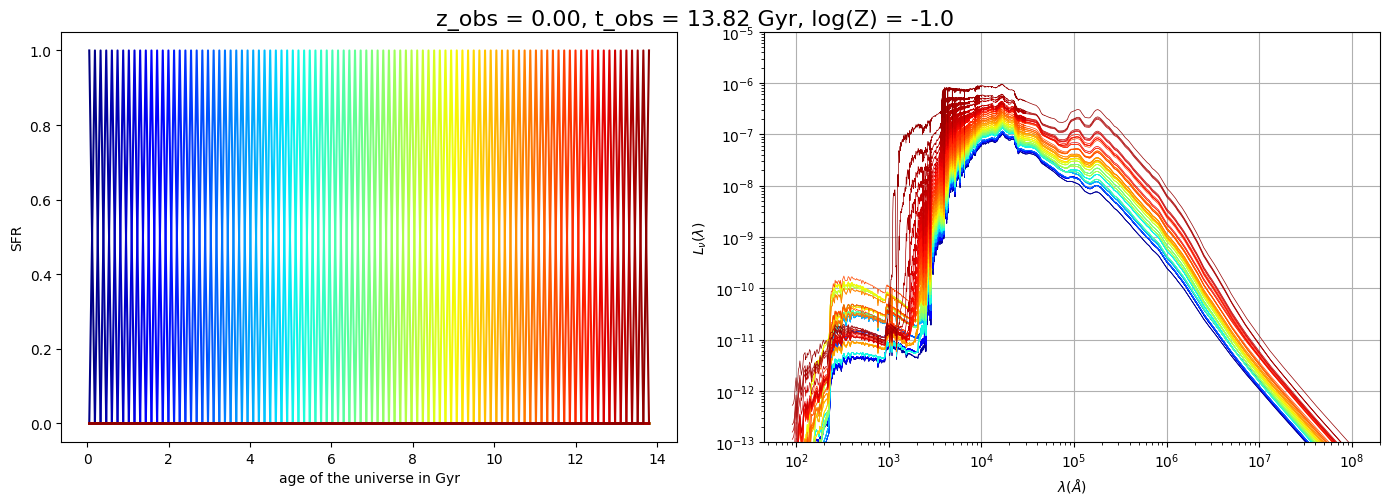

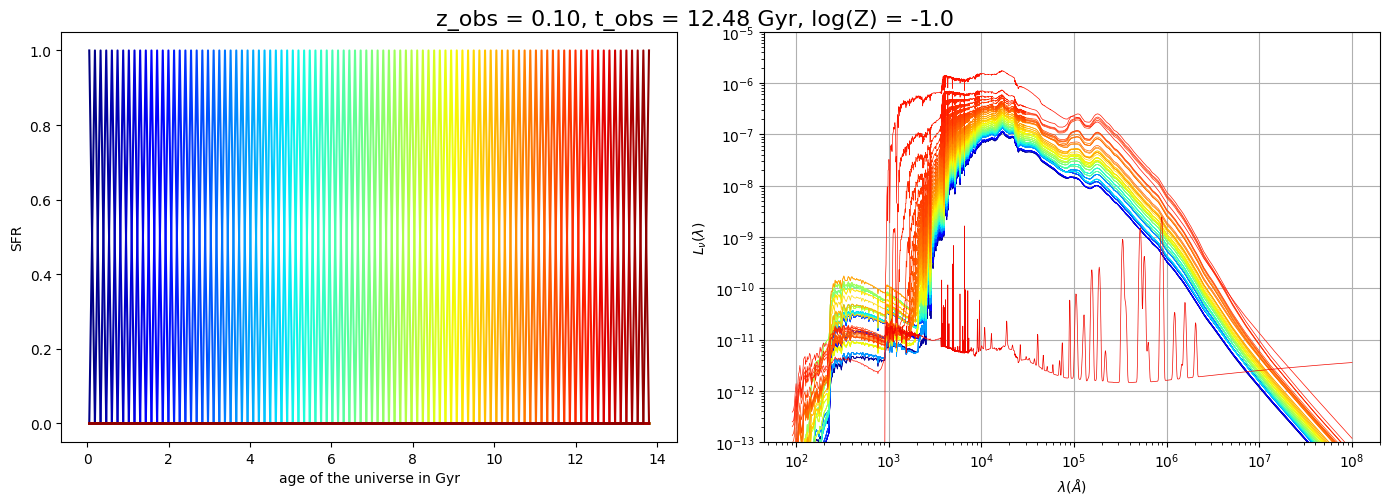

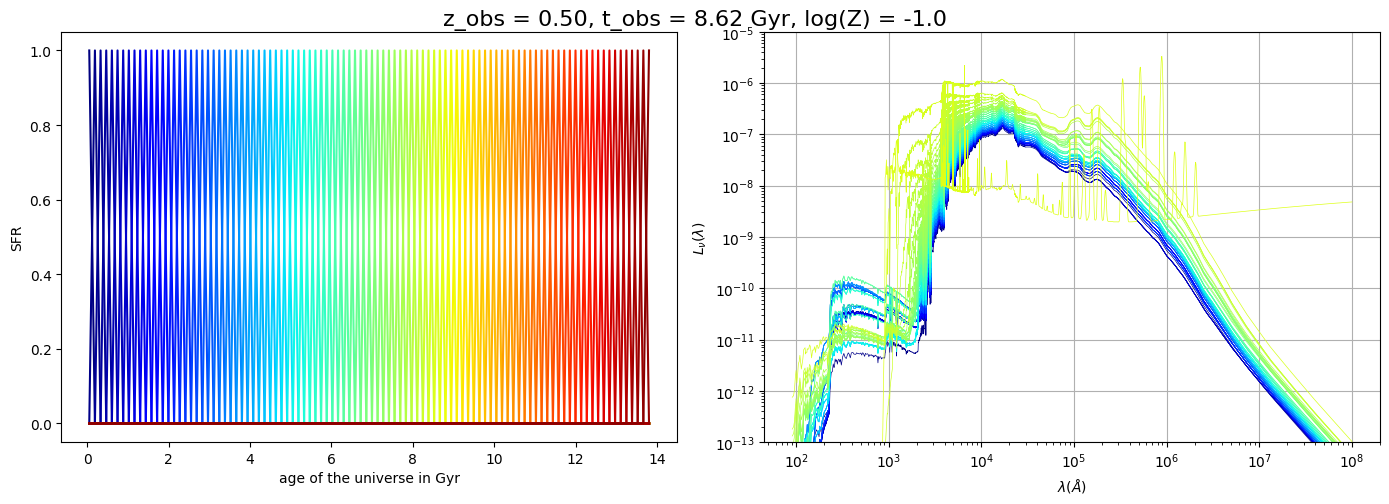

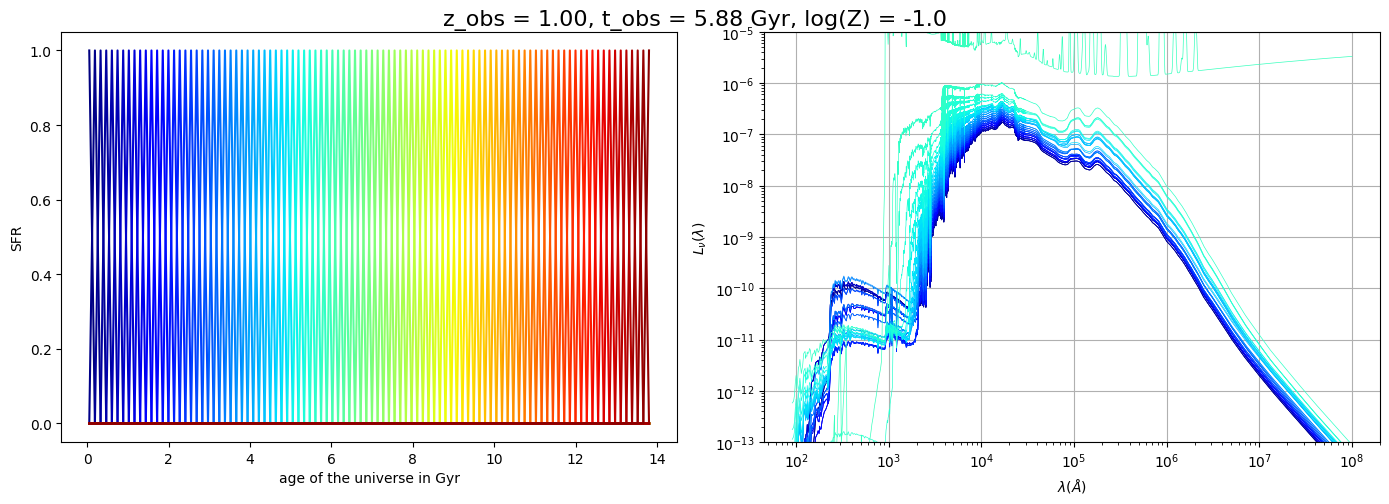

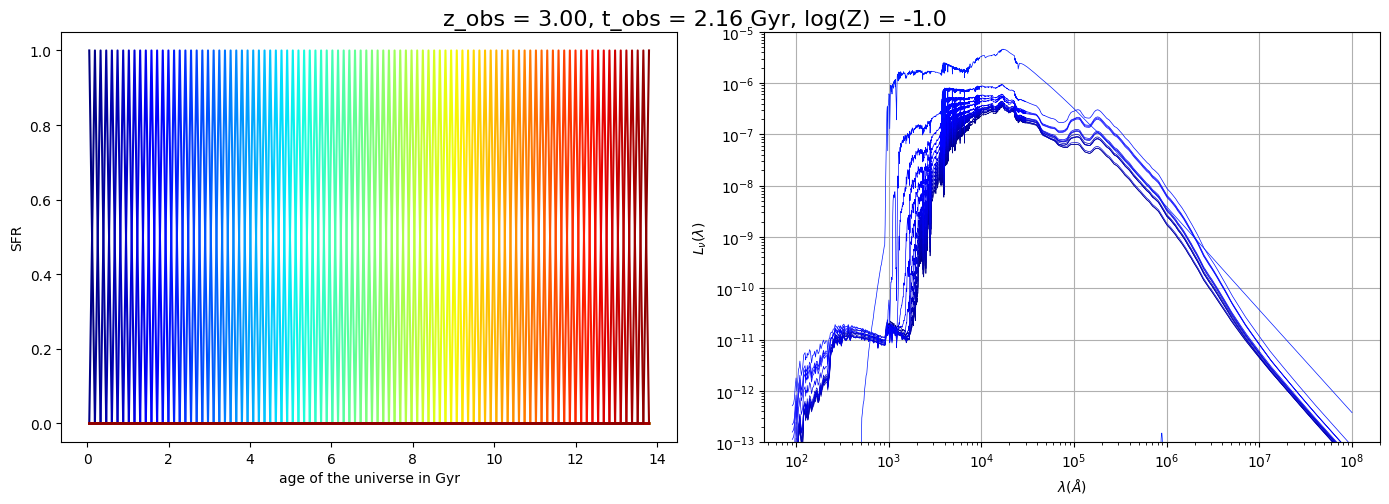

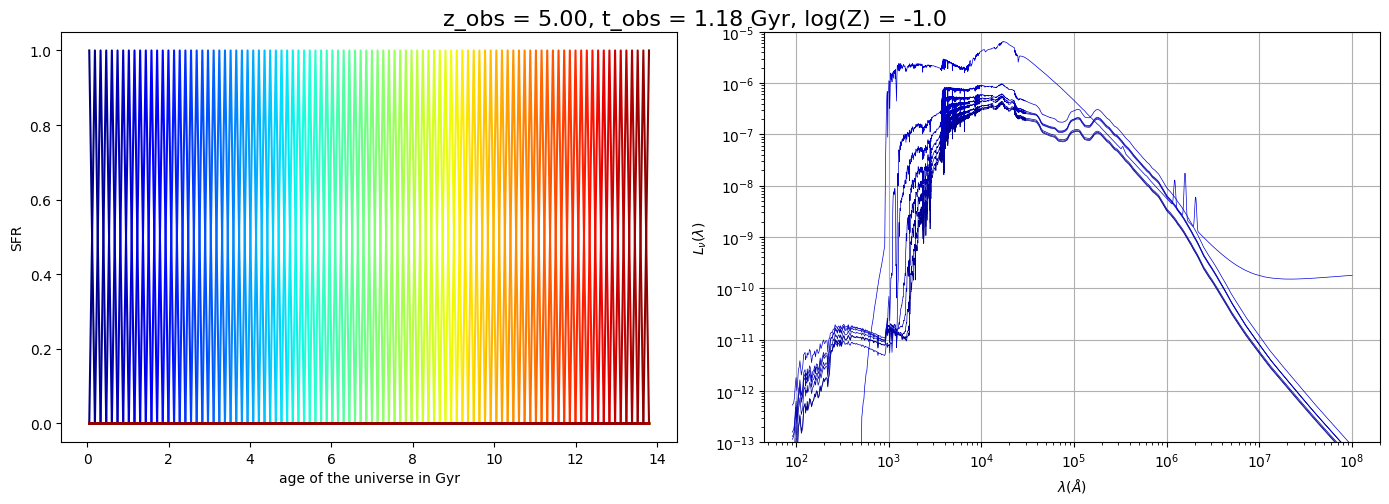

In [153]:
for redshift in all_redshifts:
    
    # info
    # =====
    z_obs = redshift
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument
    the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}"
    
    
    # Compute spectra
    # ==============
    all_sed_infos  = []
    all_sfr = []

    for idx,time in enumerate(gal_t_table):
        #gal_sfr_table = np.zeros(len(gal_t_table)) # SFR in Msun/yr
        gal_sfr_table[idx] = 1.0
    
        all_sfr.append(copy.deepcopy(gal_sfr_table))
    
        sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
        gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
        all_sed_infos.append(sed_info) 
    
        sed_info2 = calc_rest_sed_sfh_table_met_table(
        gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
    
        gal_sfr_table[idx] = 0.0
        
    # Plot
    #=====
    fig, axs = plt.subplots(1, 2,figsize=(14,5))

    ax1=axs[0]
    for idx,time in enumerate(gal_t_table):
        ax1.plot(gal_t_table, all_sfr[idx],"-",color=all_colors[idx])
    ax1.set_xlabel("age of the universe in Gyr")
    ax1.set_ylabel("SFR")

    ax2=axs[1]
    __=ax2.loglog()
    for idx,time in enumerate(gal_t_table[:-1]):
        ax2.plot(ssp_data.ssp_wave, all_sed_infos[idx].rest_sed,"-",color=all_colors[idx],lw=0.5)
    ax2.set_ylim(1e-13,1e-5)
    ax2.grid()
    ax2.set_xlabel("$\lambda (\\AA)$")
    ax2.set_ylabel("$L_\\nu(\lambda)$")
    
    plt.tight_layout()
    plt.suptitle(the_title,y=1.0,fontsize=16)
    